In [1]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
url = "https://r-marketing.r-forge.r-project.org/data/rintro-chapter13conjoint.csv"
data = pd.read_csv(url)

In [3]:
data.head()

,resp.id,ques,alt,carpool,seat,cargo,eng,price,choice
0,1,1,1,yes,6,2ft,gas,35,0
1,1,1,2,yes,8,3ft,hyb,30,0
2,1,1,3,yes,6,3ft,gas,30,1
3,1,2,1,yes,6,2ft,gas,30,0
4,1,2,2,yes,7,3ft,gas,35,1


In [4]:
data["seat"] = data["seat"].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   resp.id  9000 non-null   int64 
 1   ques     9000 non-null   int64 
 2   alt      9000 non-null   int64 
 3   carpool  9000 non-null   object
 4   seat     9000 non-null   object
 5   cargo    9000 non-null   object
 6   eng      9000 non-null   object
 7   price    9000 non-null   int64 
 8   choice   9000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 632.9+ KB


In [5]:
data = pd.get_dummies(data, dtype=np.float32)
data.head()

,resp.id,ques,alt,price,choice,carpool_no,carpool_yes,seat_6,seat_7,seat_8,cargo_2ft,cargo_3ft,eng_elec,eng_gas,eng_hyb
0,1,1,1,35,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,1,2,30,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1,1,3,30,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1,2,1,30,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1,2,2,35,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [6]:
features = ["price", "seat_7", "seat_8", "cargo_3ft", "eng_elec", "eng_hyb"]
X = data[features]
X.head()

,price,seat_7,seat_8,cargo_3ft,eng_elec,eng_hyb
0,35,0.0,0.0,0.0,0.0,0.0
1,30,0.0,1.0,1.0,0.0,1.0
2,30,0.0,0.0,1.0,0.0,0.0
3,30,0.0,0.0,0.0,0.0,0.0
4,35,1.0,0.0,1.0,0.0,0.0


In [7]:
y = data["choice"]

In [8]:
X = X.to_numpy(dtype=np.float32)
y = y.to_numpy(dtype=np.int64)

In [9]:
X = X.reshape(-1, 3, 6)
y = y.reshape(-1, 3)
X.shape, y.shape

((3000, 3, 6), (3000, 3))

In [10]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

# the choice made 1 or 2 or 3
y = y.argmax(axis=1)

In [11]:
class MLPChoice(nn.Module):
    """Some Information about MLPChoice"""
    def __init__(self, n_chosen, n_features):
        super(MLPChoice, self).__init__()
        self.n_chosen = n_chosen # choose only 1 alternative of the 3
        self.n_features = n_features
        
        self.hidden = nn.Sequential(
            nn.Linear(in_features=self.n_features, out_features=self.n_chosen, bias=False),
        )

    def forward(self, x):
        logits = self.hidden(x) # dim batch x 3 x 1
        logits = logits.squeeze() # dim batch x 3


        return logits

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
_, _, n_feat = X.shape
choice = MLPChoice(n_chosen=1, n_features=n_feat)
choice = choice.to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(choice.parameters(), lr=1e-2)

In [15]:
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset=dataset, batch_size=64)

In [16]:
# loop over the dataset multiple times

accuracies = []
losses = []
aucs = []

num_epoch = 15

for epoch in range(num_epoch):
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    choice.train()

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = choice(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)

        running_loss += loss.item() # loss per batch and we added the losses in all the batches
        
        total_correct += (predicted == labels).sum().item() # calculate the total correct = sum of the # of correct per each batch
        total_samples += labels.size(0) # sum the total number of training samples (each batch of 64 times 46 and the last batch one of 56)

    # print('Loss: {}'.format(running_loss))

    accuracy = 100 * total_correct / total_samples

    losses.append(running_loss)
    accuracies.append(accuracy)

    # print(f'Epoch {epoch+1}: Accuracy = {accuracy:.2f}%')

    choice.eval()
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in train_loader:
            outputs = choice(inputs)
            all_outputs.append(outputs)
            all_targets.append(targets)

    all_outputs = torch.cat(all_outputs).cpu().numpy()
    all_targets = torch.cat(all_targets).cpu().numpy()

    # Convert logits to probabilities using softmax
    all_probabilities = np.exp(all_outputs) / np.sum(np.exp(all_outputs), axis=1, keepdims=True)

    # Calculate AUC for each class using one-vs-rest (OvR)
    aucs.append(roc_auc_score(all_targets, all_probabilities, multi_class='ovr'))

print('Finished Training')

Finished Training


In [17]:
coef = pd.DataFrame({"feature": features, "beta": choice.hidden[0].weight.data[0]})
coef

,feature,beta
0,price,-0.171505
1,seat_7,-0.530169
2,seat_8,-0.305241
3,cargo_3ft,0.468578
4,eng_elec,-1.513180
5,eng_hyb,-0.838201


In [18]:
wtp = pd.DataFrame({'feature': coef.iloc[1:, 0], 'wtp': -(coef.iloc[1:, 1] / coef.iloc[0, 1] * 1000)})
wtp

,feature,wtp
1,seat_7,-3091.276367
2,seat_8,-1779.778931
3,cargo_3ft,2732.152588
4,eng_elec,-8822.953125
5,eng_hyb,-4887.325684


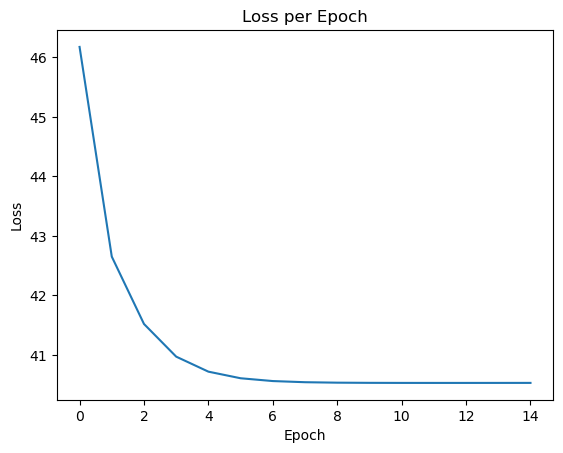

In [19]:
fig, ax = plt.subplots()
ax.plot(range(num_epoch), losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss per Epoch')
plt.show()

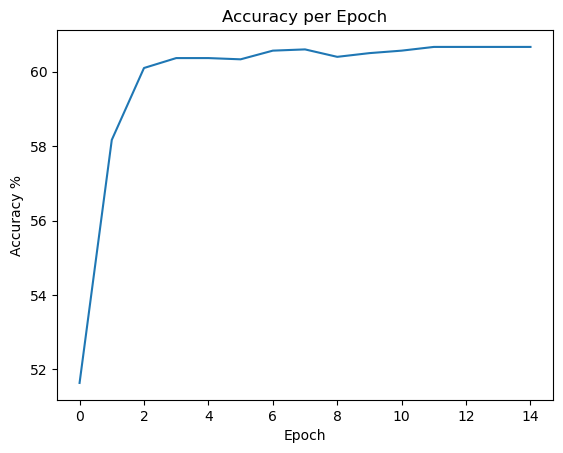

In [20]:
fig, ax = plt.subplots()
ax.plot(range(num_epoch), accuracies)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy %')
ax.set_title('Accuracy per Epoch')
plt.show()

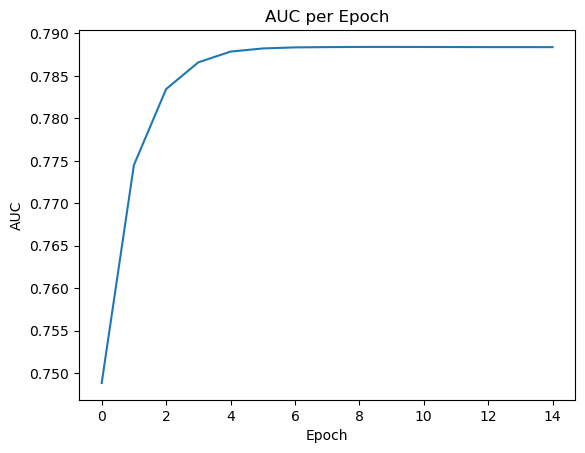

In [21]:
fig, ax = plt.subplots()
ax.plot(range(num_epoch), aucs)
ax.set_xlabel('Epoch')
ax.set_ylabel('AUC')
ax.set_title('AUC per Epoch')
plt.show()